This is essentially the same as ls_matrix.ipynb, but we're looking at the ColabFold/PDB comparisons instead of the AlphaFold/ColabFold comparisons

In [34]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
'''
We need to wrangle our RMSD data a bit before we can make any calculations.
'''

rmsd = pd.read_csv('./project_pipeline/data/two-state_cf_pdb_compared.tsv', sep='\t')

# We only need a subset of the columns
rmsd = rmsd[['uniprot', 'pdb', 'cluster', 'complex_rmsd', '2_comp']]

rmsd = rmsd.rename(columns={'complex_rmsd': 'Complex RMSD', '2_comp': 'IMAE'})
rmsd.head()

,uniprot,pdb,cluster,Complex RMSD,IMAE
0,O08967,2r09,U10-005,17.274,33.607
1,O08967,2r09,031,19.503,31.059
2,O08967,2r09,U10-001,16.866,23.513
3,O08967,2r09,U100-004,21.285,52.734
4,O08967,2r09,029,12.546,23.212


In [36]:
lineage = pd.read_csv('./project_pipeline/data/lineage_scores.csv')

lineage.head()

,uniprot,state,conformation,cluster,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length
0,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_A0A812VSQ5,2952.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2698737, 33630, 2864, 89954, 25...",2,30,8
1,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_A0A2G8JTM8,307972.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",7,30,15
2,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_UPI001469F9E4,52239.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,31
3,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_A0A8C7Z9G0,183150.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,33
4,O08967,Autoinhibited,Closed,U10-005,O08967_U10-005.a3m,UniRef100_UPI001E1BC1D8,35525.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,20


In [37]:
# Also add the cluster conformations
cluster = pd.read_csv('./project_pipeline/data/autoinhibited_cf_interface.tsv', sep='\t')

cluster['cf_conformation'] = cluster['number_interface_residues'].apply(lambda x: 'Closed' if x > 0 else 'Open')

cluster = cluster[['uniprot', 'cluster', 'cf_conformation']]

In [38]:
'''
Now we'll merge the RMSD data with the lineage scores.
'''

# Merge the RMSD and lineage data
merged = pd.merge(rmsd, lineage, on=['uniprot', 'cluster'])

# Merge the cluster data
merged = pd.merge(merged, cluster, on=['uniprot', 'cluster'])

merged.head()

,uniprot,pdb,cluster,Complex RMSD,IMAE,state,conformation,filename,uniref,taxonId,uniprot_lineage,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation
0,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A812VSQ5,2952.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 2698737, 33630, 2864, 89954, 25...",2,30,8,Closed
1,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A2G8JTM8,307972.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",7,30,15,Closed
2,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_UPI001469F9E4,52239.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,31,Closed
3,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A8C7Z9G0,183150.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,33,Closed
4,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_UPI001E1BC1D8,35525.0,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...","[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,20,Closed


In [39]:
# First the variance
var = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('var')

merged['var'] = var

merged = merged.fillna(0)

# Now the mean
mean = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('mean')

merged['mean'] = mean

# Now the max
lmax = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('max')

merged['max'] = lmax

# Min
lmin = merged.groupby(['uniprot', 'cluster'])['lineage_score'].transform('min')

merged['min'] = lmin

# Need to count the number of unirefs per cluster

counts = merged.groupby(['cluster', 'uniprot']).size().reset_index(name='counts')

print(counts)

# Now we can merge the counts with the lineage scores
lineage_counts = pd.merge(merged, counts, on=['uniprot', 'cluster'])

       cluster uniprot  counts
0          000  O08967    1580
1          000  O60741       8
2          000  P07038       6
3          000  P12931     119
4          000  P22681     970
...        ...     ...     ...
1440  U100-009  P62826    5500
1441  U100-009  Q6GQQ9     180
1442  U100-009  Q8NQJ3     100
1443  U100-009  Q96BN8     837
1444  U100-009  Q9Y6K1     172

[1445 rows x 3 columns]


In [40]:
lineage_counts.head()

,uniprot,pdb,cluster,Complex RMSD,IMAE,state,conformation,filename,uniref,taxonId,...,cluster_lineage,lineage_score,uniprot_lineage_length,cluster_lineage_length,cf_conformation,var,mean,max,min,counts
0,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A812VSQ5,2952.0,...,"[131567, 2759, 2698737, 33630, 2864, 89954, 25...",2,30,8,Closed,18.37037,7.0,13,2,28
1,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A2G8JTM8,307972.0,...,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",7,30,15,Closed,18.37037,7.0,13,2,28
2,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_UPI001469F9E4,52239.0,...,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,31,Closed,18.37037,7.0,13,2,28
3,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_A0A8C7Z9G0,183150.0,...,"[131567, 2759, 33154, 33208, 6072, 33213, 3351...",13,30,33,Closed,18.37037,7.0,13,2,28
4,O08967,2r09,U10-005,17.274,33.607,Autoinhibited,Closed,O08967_U10-005.a3m,UniRef100_UPI001E1BC1D8,35525.0,...,"[131567, 2759, 33154, 33208, 6072, 33213, 3331...",6,30,20,Closed,18.37037,7.0,13,2,28


In [41]:
pre = lineage_counts.drop(columns=['filename', 'uniref', 'taxonId', 'uniprot_lineage', 'cluster_lineage', 'lineage_score', 'cluster_lineage_length', 'state', 'conformation'])
pre = pre.drop_duplicates().reset_index(drop=True)

# What if we got rid of the uniformly sampled clusters? I.e. any cluster with U in it
pre = pre[~pre['cluster'].str.contains('U')]
pre.head()

,uniprot,pdb,cluster,Complex RMSD,IMAE,uniprot_lineage_length,cf_conformation,var,mean,max,min,counts
1,O08967,2r09,031,19.503,31.059,30,Closed,0.0,2.0,2,2,8
4,O08967,2r09,002,20.558,25.518,30,Closed,0.0,11.0,11,11,24
5,O08967,2r09,017,21.007,30.703,30,Closed,0.0,24.0,24,24,8
6,O08967,2r09,013,17.087,25.113,30,Closed,0.0,6.0,6,6,8
8,O08967,2r09,006,21.303,20.815,30,Closed,0.0,6.0,6,6,8


In [42]:
#We'll one-hot the state and conformation. 0 if Autoinhibited/Closed, 1 if Active/Open
pre['cf_conformation'] = pre['cf_conformation'].map({'Closed': 0, 'Open': 1})
pre = pre.drop(columns=['uniprot', 'cluster', 'pdb'])
pre.head()

,Complex RMSD,IMAE,uniprot_lineage_length,cf_conformation,var,mean,max,min,counts
1,19.503,31.059,30,0,0.0,2.0,2,2,8
4,20.558,25.518,30,0,0.0,11.0,11,11,24
5,21.007,30.703,30,0,0.0,24.0,24,24,8
6,17.087,25.113,30,0,0.0,6.0,6,6,8
8,21.303,20.815,30,0,0.0,6.0,6,6,8


In [43]:
# Now we'll make a dataset for the conformation
conf = pre.drop(columns=['Complex RMSD', 'IMAE'])

# Now we'll make a dataset for the Complex RMSD
rmsd = pre.drop(columns=['IMAE', 'cf_conformation'])

# Finally, we'll make a dataset for the IMAE
imae = pre.drop(columns=['Complex RMSD', 'cf_conformation'])

In [44]:
# Split the data into features and target
X = conf.drop('cf_conformation', axis=1)
Y = conf['cf_conformation']

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier()

In [46]:
Y_pred = rf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9949001736111112


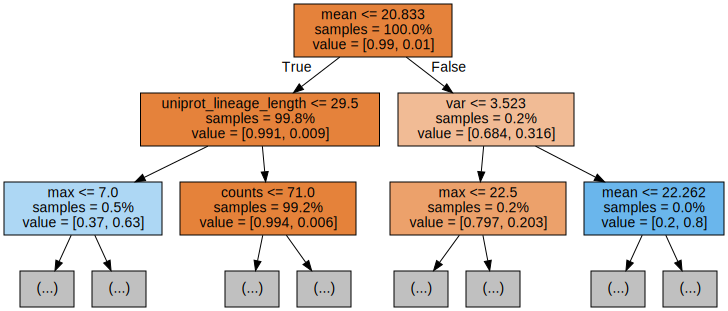

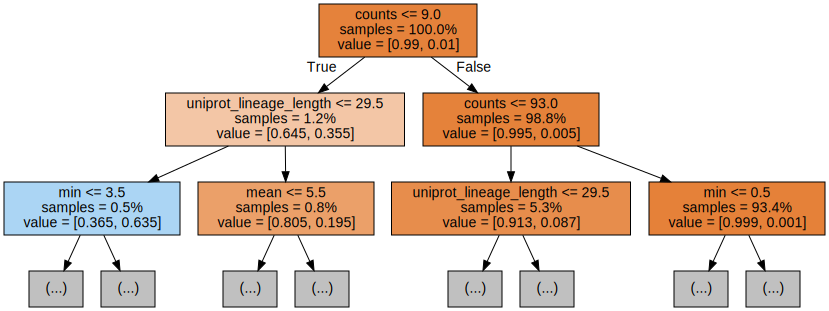

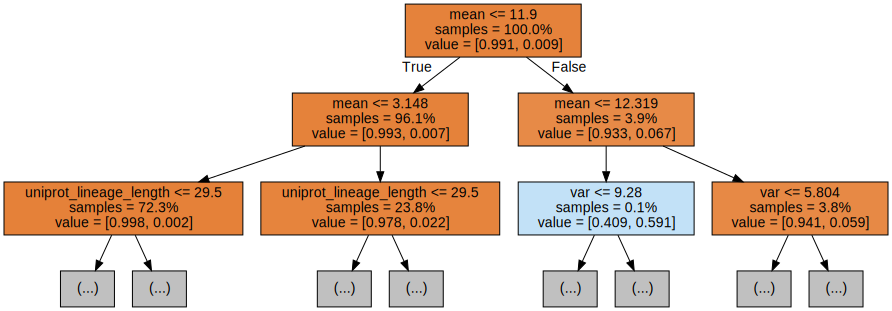

In [47]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [48]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f335383c050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f336c60e810>})

In [49]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 374}


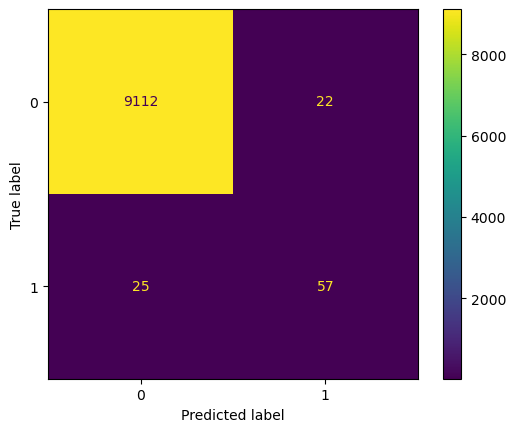

In [50]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [51]:
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9953342013888888
Precision: 0.8305084745762712
Recall: 0.5975609756097561


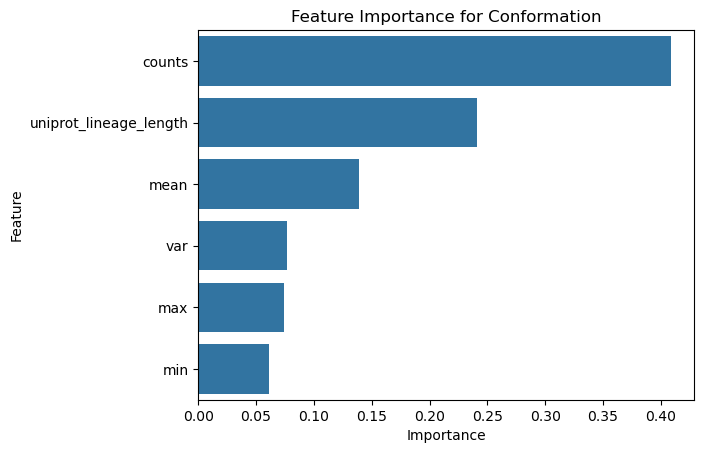

In [70]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
f = sns.barplot(x=feature_importances, y=feature_importances.index)
f.set_title('Feature Importance for Conformation')
f.set_xlabel('Importance')
f.set_ylabel('Feature')

plt.savefig('./project_pipeline/data/figures/cf_pdb_conformation_feature_importance.png')

In [53]:
# Split the data into features and target
Xi = imae.drop('IMAE', axis=1)
Yi = imae['IMAE']

# Split the data into training and test sets
Xi_train, Xi_test, Yi_train, Yi_test = train_test_split(Xi, Yi, test_size=0.2, random_state=42)

In [54]:
rf = RandomForestRegressor()
rf.fit(Xi_train, Yi_train)

RandomForestRegressor()

In [55]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_searchi = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_searchi.fit(Xi_train, Yi_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3351c5d850>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3351c5da30>})

In [56]:
# Create a variable for the best model
best_rfi = rand_searchi.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_searchi.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 195}


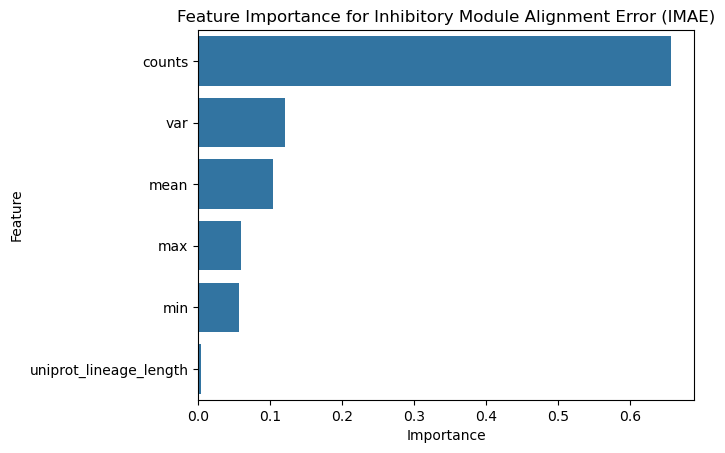

In [71]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importancesi = pd.Series(best_rfi.feature_importances_, index=Xi_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
f = sns.barplot(x=feature_importancesi, y=feature_importancesi.index)
f.set_title('Feature Importance for Inhibitory Module Alignment Error (IMAE)')
f.set_xlabel('Importance')
f.set_ylabel('Feature')

plt.savefig('./project_pipeline/data/figures/cf_pdb_imae_feature_importance.png')

In [58]:
# Split the data into features and target
Xc = rmsd.drop('Complex RMSD', axis=1)
Yc = rmsd['Complex RMSD']

# Split the data into training and test sets
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Yc, test_size=0.2, random_state=42)

In [59]:
rf = RandomForestRegressor()
rf.fit(Xc_train, Yc_train)

RandomForestRegressor()

In [60]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_searchc = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_searchc.fit(Xc_train, Yc_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f33539db3b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3353ac2b40>})

In [61]:
# Create a variable for the best model
best_rfc = rand_searchc.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_searchc.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 167}


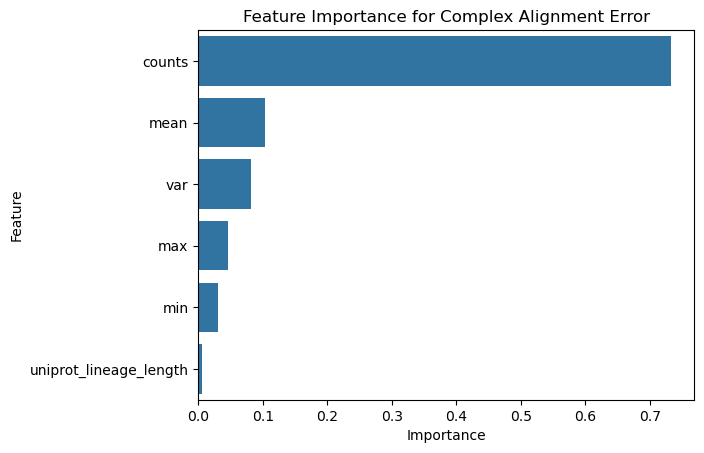

In [72]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importancesc = pd.Series(best_rfc.feature_importances_, index=Xc_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
f = sns.barplot(x=feature_importancesc, y=feature_importancesc.index)
f.set_title('Feature Importance for Complex Alignment Error')
f.set_xlabel('Importance')
f.set_ylabel('Feature')

plt.savefig('./project_pipeline/data/figures/cf_pdb_complex_rmsd_feature_importance.png')

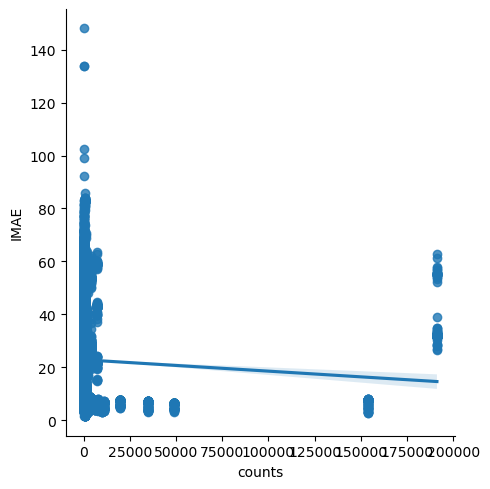

In [73]:
sns.lmplot(pre, x='counts', y='IMAE')

plt.savefig('./project_pipeline/data/figures/cf_pdb_imae_vs_counts.png')